In [1]:
import time
import torch
import torch.nn as nn
import random
from sklearn.model_selection import KFold
import torchvision
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import datasets
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
from tqdm import tqdm
from PIL import Image

c:\Users\andre\anaconda3\envs\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
def load_data(batch_size=64, train=True):
    '''
    Loads a subset of image data, resizes images to 120x120, and normalizes pixel values to [-1, 1].
    '''

    dataset = []
    batch = []
    num = 10000  # number of images to load

    for i, file in enumerate(tqdm(os.listdir('./album_covers_512'))):
        if i >= num:
            break
        img_path = './album_covers_512/' + file
        with Image.open(img_path) as img:
            # Resize the image and convert to array
            img_resized = img.resize((120, 120))
            img_array = np.array(img_resized)

            # Normalize pixel values to [-1, 1]
            img_normalized = (img_array / 127.5) - 1

            # Append to batch, transposing to CHW format as needed by PyTorch
            batch.append(img_normalized.transpose((2, 0, 1)))  # Convert HWC to CHW

            if len(batch) == batch_size:
                dataset.append(np.stack(batch))  # Use np.stack to ensure shape consistency
                batch = []

    # Append the last batch if it has less than batch_size elements
    if batch:
        dataset.append(np.stack(batch))

    # Convert the list of batches into a single NumPy array, if needed
    if len(dataset) > 1:
        dataset = np.concatenate([np.expand_dims(b, 0) for b in dataset])
    else:
        dataset = dataset[0]

    return dataset

# Usage example
data = load_data(batch_size=64)
data_tensor = torch.from_numpy(data)

 13%|█▎        | 10000/79734 [00:35<04:05, 284.29it/s]


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 64 and the array at index 156 has size 16

In [9]:
dataset = load_data(batch_size=128, train=True)
dataset = torch.from_numpy(dataset)

 13%|█▎        | 10000/79734 [00:35<04:07, 282.02it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (79,) + inhomogeneous part.

In [4]:
def plot_image(image, index=0, title=None, figsize=(8, 8)):
    # Ensure the image tensor is on the CPU and detached
    image = image.cpu().detach()
    
    # Convert PyTorch tensor to numpy if necessary
    if isinstance(image, torch.Tensor):
        image = image.numpy()

    # Check and handle a batch of images
    if image.ndim == 4:
        if index >= image.shape[0]:
            raise ValueError("Index is out of bounds for the batch size.")
        image = image[index]

    # Normalize the image data to [0, 1]
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # Convert CHW to HWC for visualization
    image = image.transpose(1, 2, 0)

    # Plotting
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()

torch.Size([77, 128, 3, 512, 512])
image shape: torch.Size([3, 512, 512])


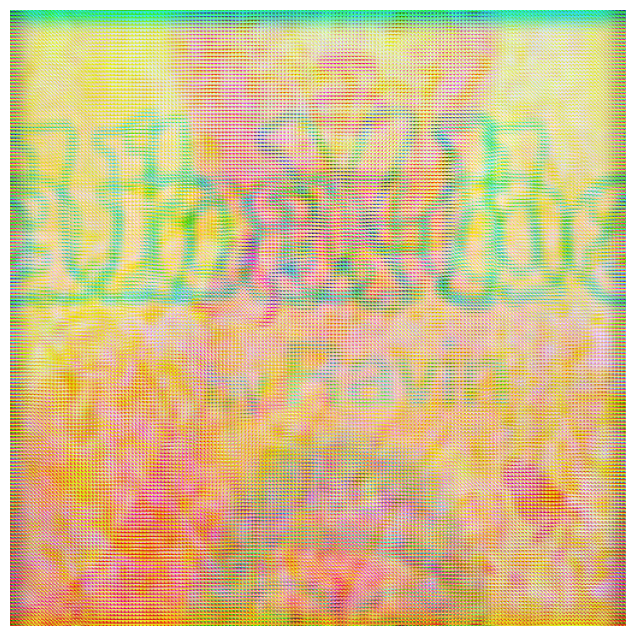

In [5]:
print(dataset.shape)
ex_image = dataset[random.randint(0,76), random.randint(0,127)]
print("image shape:", ex_image.shape)

plot_image(ex_image)

In [6]:
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()

        kernel_size = 4
        padding = 1
        stride = 2
        alpha = 0.2
        
        self.net = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size, stride, padding),
            nn.LeakyReLU(alpha),
            nn.Conv2d(128, 256, kernel_size, stride, padding),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(alpha),
            nn.Conv2d(256, 512, kernel_size, stride, padding),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(alpha),
            nn.Conv2d(512, 512, kernel_size, stride, padding),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(alpha),
            nn.Conv2d(512, 1024, kernel_size, stride, padding),
            nn.InstanceNorm2d(1024, affine=True),
            nn.LeakyReLU(alpha),
        )
        self.output = nn.Linear(4 * 4 * 1024, 1)
        
    def forward(self, x):
        x = self.net(x)
        x = torch.reshape(x, (-1, 4 * 4 * 1024))
        return self.output(x)

In [7]:
if len(ex_image.shape) == 3:  # Check if the batch dimension is missing
    ex_image = ex_image.unsqueeze(0)  
input_shape = (3, 512, 512)  # Shape: Channels, Height, Width
discriminator = Critic(input_shape)
ex_output = discriminator(ex_image.float())

plot_image(ex_image)
print("Output of the discriminator given this input:", ex_output[0].detach().numpy()[0])

TypeError: Critic.__init__() takes 1 positional argument but 2 were given

In [42]:
class Generator(nn.Module):
    def __init__(self, input_size, output_shape=(3, 120, 120)):
        super(Generator, self).__init__()

        self.input_size = input_size
        self.output_shape = output_shape
        d_dim = input_size  # Assuming d_dim is the size of the input latent vector

        # Initial linear layer
        self.linear = nn.Linear(d_dim, 4*4*1024)  # Initialize linear layer to map latent vector

        # Define the network using sequential model
        self.net = nn.Sequential(
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1),  # Output is (512) x 8 x 8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),  # Output is (256) x 16 x 16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),  # Output is (128) x 32 x 32
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # Output is (64) x 64 x 64
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, self.output_shape[0], 4, 2, 1),  # Final output is 128 x 128
            nn.Tanh()
        )

    def forward(self, z):
        x = self.linear(z)
        x = x.view(-1, 1024, 4, 4)
        output = self.net(x)
        # Crop or adjust dimensions as needed to match the desired output_shape
        return output[:, :, :self.output_shape[1], :self.output_shape[2]]

torch.Size([1, 3, 128, 128])


C:\Users\andre\AppData\Local\Temp\ipykernel_28188\3619678237.py:16: RuntimeWarning: invalid value encountered in divide
  image = (image - np.min(image)) / (np.max(image) - np.min(image))
c:\Users\andre\anaconda3\envs\myenv\Lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


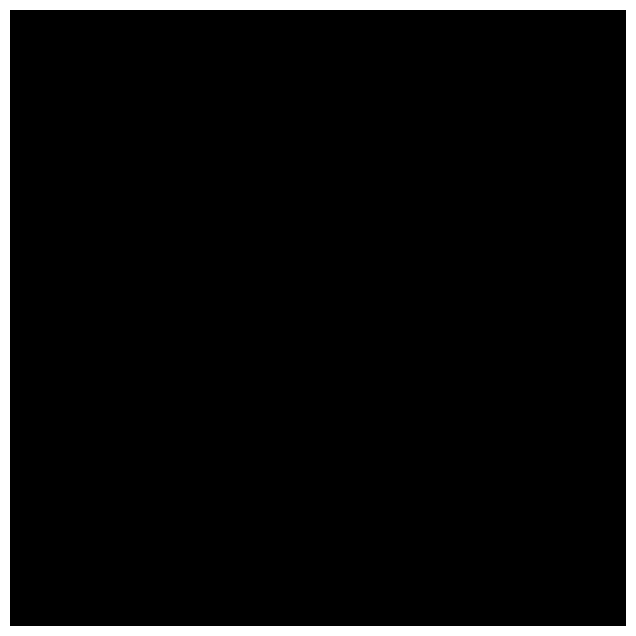

In [44]:
test_gen = Generator(128, (3, 512, 512))
print(test_gen(torch.rand(1, 128)).shape)  # Should print the shape (1, 3, 512, 512)

# Generate a noise vector and create an image
noise = (torch.rand(1, 128) - 0.5) / 0.5  # Normalizing input noise vector
test_output = test_gen(noise)
plot_image(test_output.detach().byte())

In [48]:
LAMBDA_GP = 10

def gradient_penalty(critic, real, fake):
  BATCHSIZE, C, H, W = real.shape
  epsilon = torch.rand((BATCHSIZE,1,1,1)).repeat(1,C,H,W)
  # Interpolating real and fake image with random epsilon per image
  interpolated_images = real * epsilon + fake * (1 - epsilon)

  # Calculate critic scores
  mixed_score = D(interpolated_images)

  # Gradient of mixed score in respect to the interpolated images
  gradient = torch.autograd.grad(
      inputs=interpolated_images,
      outputs=mixed_score,
      grad_outputs=torch.ones_like(mixed_score),
      create_graph=True,
      retain_graph=True,
  )[0]

  # Flatten the gradient
  gradient = gradient.view(gradient.shape[0],-1)
  # Take the L2 Norm
  gradient_norm = gradient.norm(2,dim=1)
  gradient_penalty = torch.mean((gradient_norm-1)**2)
  return gradient_penalty

# Critic Training
def C_train(x):
  C_optimizer.zero_grad()

  # Creating inputs of real data
  realX, realY = x, torch.ones(x.size(0), 1)
  C_real_output = C(realX)
  
  # Creating inputs of generated data
  z = torch.randn(x.size(0),d_dim)
  fakeX, fakeY = G(z), torch.zeros(x.size(0), 1)
  C_fake_output = C(fakeX.detach())
  C_fake_output = C_fake_output.view(x.size(0), 1)
  
  # Gradient Penalty
  gp = gradient_penalty(C,realX, fakeX)

  # Take the average
  C_loss = -torch.mean(C_real_output) + torch.mean(C_fake_output) + LAMBDA_GP * gp
  C_loss.backward(retain_graph=True)
  C_optimizer.step()     

  return C_loss.item()

# Generator Training
def G_train(size):
  G_optimizer.zero_grad()

  z = torch.randn(size,d_dim)
  y = torch.ones(size, 1)

  G_output = G(z)
  C_output = C(G_output)
  C_output = C_output.view(size, 1)
  G_loss = -torch.mean(C_output)
  
  G_loss.backward()
  G_optimizer.step()
  
  return G_loss.item()

In [45]:
def training(generator, discriminator, loss, g_optimizer, d_optimizer, train_dataloader, n_epochs, update_interval, noise_samples):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)

    g_losses = []
    d_losses = []
    
    for epoch in range(n_epochs):
        for i, images in enumerate(tqdm(train_dataloader)):  # Adjusted for direct unpacking
            images = images.to(device).float()
            
            # Training the discriminator on real images
            real_classifications = discriminator(images)
            real_labels = torch.ones(images.size(0), 1, device=device)

            # Training the discriminator on fake images
            noise = (torch.rand(images.size(0), noise_samples, device=device) - 0.5) / 0.5
            fake_inputs = generator(noise)
            fake_classifications = discriminator(fake_inputs)
            fake_labels = torch.zeros(images.size(0), 1, device=device)

            # Combine losses
            d_loss_real = loss(real_classifications, real_labels)
            d_loss_fake = loss(fake_classifications, fake_labels)
            d_loss = (d_loss_real + d_loss_fake) / 2
            
            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

            if i % update_interval == 0:
                d_losses.append(round(d_loss.item(), 2))

            # Updating the generator
            noise = (torch.rand(images.size(0), noise_samples, device=device) - 0.5) / 0.5
            fake_inputs = generator(noise)
            fake_classifications = discriminator(fake_inputs)
            
            # Inverting labels here: generator tries to fool the discriminator
            g_loss = loss(fake_classifications, real_labels)

            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()

            if i % update_interval == 0:
                g_losses.append(round(g_loss.item(), 2))
                
    return (generator, discriminator), (g_losses, d_losses)


In [46]:
lr = 0.0001               # The size of the step taken when doing gradient descent
batch_size = 32        # The number of images being trained on at once
update_interval = 11   # The number of batches trained on before recording loss
n_epochs = 5            # The number of times we train through the entire dataset
noise_samples = 256    # The size of the noise input to the Generator

loss_function = nn.BCELoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
G_model = Generator(noise_samples, (3,512,512)).to(device)
D_model = Discriminator((3,512,512)).to(device)
G_optimizer = torch.optim.Adam(G_model.parameters(), lr=lr*2)     # This is an improved version of SGD which decreases the learning rate over time to avoid leaving a minima
D_optimizer = torch.optim.Adam(D_model.parameters(), lr=lr)       # This is an improved version of SGD which decreases the learning rate over time to avoid leaving a minima

train_dataset = dataset

models, losses = training(G_model, D_model, loss_function, G_optimizer, D_optimizer, train_dataset, n_epochs, update_interval, noise_samples)

G_model, D_model = models
g_losses, d_losses = losses

plt.plot(np.arange(len(g_losses)) * batch_size * update_interval, g_losses)
plt.title("training curve for generator")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()

plt.plot(np.arange(len(d_losses)) * batch_size * update_interval, d_losses)
plt.title("training curve for discriminator")
plt.xlabel("number of images trained on")
plt.ylabel("loss")
plt.show()

Using device: cuda


  0%|          | 0/77 [00:01<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x16384 and 262144x1)

In [15]:
# Assuming you have a function plot_image to display images

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the correct device if it's not already
D_model.to(device)
G_model.to(device)

# Make sure the example image 'ex_image' is on the correct device
ex_image = ex_image.to(device).float()  # Convert to float and move to GPU
trained_output = D_model(ex_image)

# Assuming plot_image handles tensors on CPU
plot_image(ex_image.cpu().detach())  # Move tensor back to CPU for plotting
print("Output of the discriminator given this input:", trained_output[0].detach().cpu().numpy()[0])
plt.show()

# Generate noise and process it through the generator
noise = (torch.rand(1, noise_samples, device=device) - 0.5) / 0.5  # Create noise directly on the GPU
trained_gen = G_model(noise)

# Assuming plot_image handles tensors on CPU
plot_image(trained_gen.detach().cpu())  # Move tensor back to CPU for plotting

# Pass the generated image through the discriminator
trained_output = D_model(trained_gen.float())  # Ensure the generated image is float

print("Output of the discriminator given this generated input:", trained_output[0].detach().cpu().numpy()[0])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x262144 and 4194304x128)

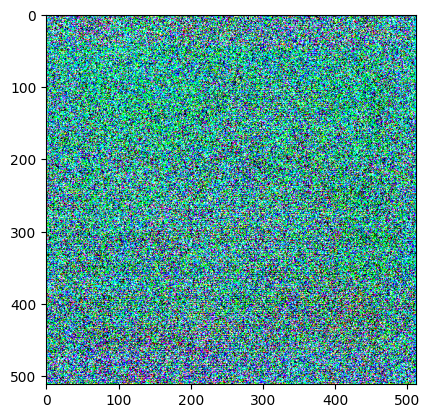

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure that G_model is on the correct device
G_model = G_model.to(device)

# Generate noise on the same device as G_model
noise = (torch.rand(1, 256, device=device) - 0.5) / 0.5

# Pass noise through the generator and then move the result to CPU for plotting
trained_output = G_model(noise).cpu()

# Call plot_image with the detached tensor
plot_image(trained_output.detach())

In [ ]:
import itertools

# Define hyperparameters options
lr_options = [2e-4, 1e-4, 3e-4, 9e-3, 5e-4]
batch_size_options = [16, 32, 64, 128]
noise_size_options = [256, 512, 1024, 2048]
update_interval_options = [10, 9, 11]
n_epochs_options = [5]

# Generate all combinations of hyperparameters
all_combinations = list(itertools.product(lr_options, batch_size_options, noise_size_options, update_interval_options, n_epochs_options))

# Keep track of the best hyperparameters and their performance
best_loss = float('inf')
best_hyperparams = {}

for combination in all_combinations:
    # Unpack the hyperparameters
    lr, batch_size, noise_size, update_interval, n_epochs = combination
    
    # Assuming the CelebA image shape
    image_shape = (3, 109, 89)
    
    # Create your model, optimizer, dataloader, etc. using these hyperparameters
    generator = Generator(noise_size, image_shape).to(device)
    discriminator = Discriminator(image_shape).to(device)
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=lr)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=lr)
    # Assume dataloader is defined elsewhere with the given batch_size
    # dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Assume the existence of a function `training` that trains your model and returns the final loss
    _, losses = training(generator, discriminator, nn.BCELoss(), g_optimizer, d_optimizer, dataset, n_epochs, update_interval, noise_size)
    
    # Compute the average loss
    g_losses, d_losses = losses
    avg_loss = (sum(g_losses) / len(g_losses)) + (sum(d_losses) / len(d_losses))
    avg_loss /= 2  # Because we added two losses, we take their average
    
    # Compare the final loss with the best one seen so far
    print(f"Average Loss for combination {combination}: {avg_loss}")
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_hyperparams = {
            'lr': lr,
            'batch_size': batch_size,
            'noise_size': noise_size,
            'update_interval': update_interval,
            'n_epochs': n_epochs
        }

# Output the best hyperparameters and their performance
print(f"Best Loss: {best_loss}")
print(f"Best Hyperparameters: {best_hyperparams}")
